Basic sequencing
================

In this tutorial we will demonstrate basic sequencer based operations (see section [Sequencer](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/documentation/sequencer.html)). This includes creating a sequence, consisting of waveforms and a simple Q1ASM program,
and executing this sequence synchronously on multiple sequencers.

The sequence is going to consecutively play two waveforms, a gaussian and block with a duration of 20ns each, with an increasing wait period
in between them. We will increase the wait period 20ns a 100 times after which the sequence is stopped. The sequence will also trigger marker
output 1 at every interval, so that the sequence can be easily monitored on an oscilloscope.

We can perform this tutorial with either a Pulsar or a Cluster QCM/QRM . We use the term 'QxM' encompassing both QCM and QRM modules.

To run this tutorial please make sure you have installed and enabled ipywidgets: 
```
pip install ipywidgets
jupyter nbextension enable –-py widgetsnbextension
```

Setup
-----

First, we are going to import the required packages.

In [1]:
# Import ipython widgets
import json
import math
import os

import ipywidgets as widgets
import matplotlib.pyplot
import numpy

# Set up the environment.
import scipy.signal
from IPython.display import display
from ipywidgets import fixed, interact, interact_manual, interactive

from qblox_instruments import Cluster, PlugAndPlay, Pulsar

### Scan For Devices

We scan for the available devices connected via ethernet using the Plug & Play functionality of the Qblox Instruments package (see [Plug & Play](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/api_reference/pnp.html) for more info).

In [2]:
# Scan for available devices and display
with PlugAndPlay() as p:
    # get info of all devices
    device_list = p.list_devices()
    device_keys = list(device_list.keys())

# create widget for names and ip addresses
connect = widgets.Dropdown(
    options=[(device_list[key]["description"]["name"]) for key in device_list.keys()],
    description="Select Device",
)
print(
    "The following widget displays all the existing modules that are connected to your PC which includes the Pulsar modules as well as a Cluster. Select the device you want to run the notebook on."
)
display(connect)

The following widget displays all the existing modules that are connected to your PC which includes the Pulsar modules as well as a Cluster. Select the device you want to run the notebook on.


Dropdown(description='Select Device', options=('cluster-mm',), value='cluster-mm')

#### Pulsar QxM <a id='pulsar_setup'></a>
Run these cells after selecting the your Pulsar module. Skip to the [Cluster QxM section](#cluster_setup) below if you have selected a Cluster module.

In [6]:
Pulsar.close_all()

# Retrieve device name and IP address
device_name = connect.value
device_number = connect.options.index(device_name)
ip_address = device_list[device_keys[device_number]]["identity"]["ip"]

# Connect to device and reset
qxm = Pulsar(f"{device_name}", ip_address)
qxm.reset()
print(f"{device_name} connected at {ip_address}")
print(qxm.get_system_state())

pulsar-qcm connected at 192.168.0.3
Status: OKAY, Flags: NONE, Slot flags: NONE


Skip to the next section [(Generate Waveform)](#gen_wf) if you are not using a cluster. 

#### Cluster QxM <a id='cluster_setup'></a>
First we connect to the Cluster using its IP address. Go to the [Pulsar QxM section](#pulsar_setup) if you are using a Pulsar.


In [3]:
# close all previous connections to the cluster
Cluster.close_all()

# Retrieve device name and IP address
device_name = connect.value
device_number = connect.options.index(device_name)
ip_address = device_list[device_keys[device_number]]["identity"]["ip"]


# connect to the cluster and reset
cluster = Cluster(device_name, ip_address)
cluster.reset()

print(f"{device_name} connected at {ip_address}")

cluster-mm connected at 192.168.1.0


We then find all available cluster modules to connect to them individually.

In [4]:
# Find all QRM/QCM modules
available_slots = {}
for module in cluster.modules:
    # if module is currently present in stack
    if cluster._get_modules_present(module.slot_idx):
        # check if QxM is RF or baseband
        if module.is_rf_type:
            available_slots[f"module{module.slot_idx}"] = ["QCM-RF", "QRM-RF"][
                module.is_qrm_type
            ]
        else:
            available_slots[f"module{module.slot_idx}"] = ["QCM", "QRM"][
                module.is_qrm_type
            ]

# List of all QxM modules present
connect_qxm = widgets.Dropdown(options=[key for key in available_slots.keys()])

print(available_slots)
# display widget with cluster modules
print()
print("Select the QxM module from the available modules in your Cluster:")
display(connect_qxm)

{'module2': 'QCM', 'module4': 'QRM'}

Select the QxM module from the available modules in your Cluster:


Dropdown(options=('module2', 'module4'), value='module2')

Finally, we connect to the selected Cluster module. 

In [5]:
# Connect to the cluster QxM module
module = connect_qxm.value
qxm = getattr(cluster, module)
print(f"{available_slots[connect_qxm.value]} connected")
print(cluster.get_system_state())

QCM connected
Status: OKAY, Flags: NONE, Slot flags: NONE


Generate waveforms <a id='gen_wf'></a>
------------------

Next, we need to create the gaussian and block waveforms for the sequence.

In [6]:
# Waveform parameters
waveform_length = 20  # nanoseconds

# Waveform dictionary (data will hold the samples and index will be used to select the waveforms in the instrument).
waveforms = {
    "gaussian": {
        "data": scipy.signal.gaussian(
            waveform_length, std=0.12 * waveform_length
        ).tolist(),
        "index": 0,
    },
    "block": {"data": [1.0 for i in range(0, waveform_length)], "index": 1},
}

Let's plot the waveforms to see what we have created.

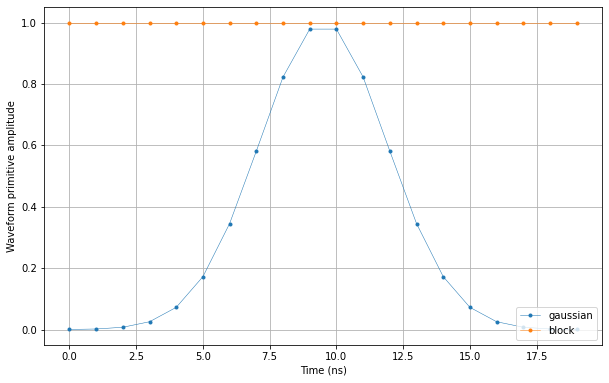

In [7]:
time = numpy.arange(0, max(map(lambda d: len(d["data"]), waveforms.values())), 1)
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(10, 10 / 1.61))

for wf, d in waveforms.items():
    ax.plot(time[: len(d["data"])], d["data"], ".-", linewidth=0.5, label=wf)

ax.legend(loc=4)
ax.yaxis.grid()
ax.xaxis.grid()
ax.set_ylabel("Waveform primitive amplitude")
ax.set_xlabel("Time (ns)")

matplotlib.pyplot.draw()
matplotlib.pyplot.show()

Create Q1ASM program
--------------------

Now that we have the waveforms for the sequence, we need a Q1ASM program that sequences the waveforms as previously described.

In [8]:
# Sequence program.
seq_prog = """
       move      100,R0   #Loop iterator.
       move      20,R1    #Initial wait period in ns.
       wait_sync 4        #Wait for sequencers to synchronize and then wait another 4ns.

loop:  set_mrk   1        #Set marker output 1.
       play      0,1,4    #Play a gaussian and a block on output path 0 and 1 respectively and wait 4ns.
       set_mrk   0        #Reset marker output 1.
       upd_param 16       #Update parameters and wait the remaining 16ns of the waveforms.

       wait      R1       #Wait period.

       play      1,0,20   #Play a block and a gaussian on output path 0 and 1 respectively and wait 20ns.
       wait      1000     #Wait a 1us in between iterations.
       add       R1,20,R1 #Increase wait period by 20ns.
       loop      R0,@loop #Subtract one from loop iterator.

       stop               #Stop the sequence after the last iteration.
"""

Upload sequence
---------------

Now that we have the waveforms and Q1ASM program, we can combine them in a sequence stored in a JSON file.

In [9]:
# Add sequence to single dictionary and write to JSON file.
sequence = {
    "waveforms": waveforms,
    "weights": {},
    "acquisitions": {},
    "program": seq_prog,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

Let's write the JSON file to the instruments. We will use sequencer 0 and 1, which will drive outputs $\text{O}^{[1-2]}$ and $\text{O}^{[3-4]}$ respectively.

In [ ]:
# Upload sequence.
qxm.sequencer0.sequence("sequence.json") 
qxm.sequencer1.sequence("sequence.json") 

Play sequence
-------------

The sequence has been uploaded to the instrument. Now we need to configure the sequencers in the instrument to use the `wait_sync` instruction
at the start of the Q1ASM program to synchronize.

In [11]:
# Configure the sequencers to synchronize.
qxm.sequencer0.sync_en(True)
qxm.sequencer1.sync_en(True)

# Map sequencers to specific outputs (but first disable all sequencer connections).
for sequencer in qxm.sequencers:
    for out in range(0, 4):
        if hasattr(sequencer, "channel_map_path{}_out{}_en".format(out % 2, out)):
            sequencer.set("channel_map_path{}_out{}_en".format(out % 2, out), False)

# If it is a QRM, we only map sequencer 0 to the outputs.
qxm.sequencer0.channel_map_path0_out0_en(True)
qxm.sequencer0.channel_map_path1_out1_en(True)
if qxm.is_qcm_type:
    qxm.sequencer1.channel_map_path0_out2_en(True)
    qxm.sequencer1.channel_map_path1_out3_en(True)

Now let's start the sequence. If you want to observe the sequence, this is the time to connect an oscilloscope to marker output 1 and one or more
of the four outputs. Configure the oscilloscope to trigger on the marker output 1.

In [12]:
# Arm and start both sequencers.
qxm.arm_sequencer(0)
qxm.arm_sequencer(1)
qxm.start_sequencer()

# Print status of both sequencers.
print(qxm.get_sequencer_state(0))
print(qxm.get_sequencer_state(1))

Status:
Status: STOPPED, Flags: NONE
Status: STOPPED, Flags: NONE


Stop
----

Finally, let's stop the sequencers if they haven't already and close the instrument connection. One can also display a detailed snapshot containing the instrument parameters before 
closing the connection by uncommenting the corresponding lines. 

In [ ]:
# Stop both sequencers.
qxm.stop_sequencer()

# Print status of both sequencers (should now say it is stopped).
print(qxm.get_sequencer_state(0))
print(qxm.get_sequencer_state(1))
print()

# Uncomment the following to print an overview of the instrument parameters.
# Print an overview of the instrument parameters.
# print("Snapshot:")
# qxm.print_readable_snapshot(update=True)

# Close the instrument connection.
Pulsar.close_all()
Cluster.close_all()